In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("Keras version:", keras.__version__)

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

2024-08-02 00:22:48.183083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.15.0
Keras version: 2.15.0


In [9]:
# Model parameters

bias = np.array([-3.57712]).reshape(1, ) # The intercept
weights = np.array([[3.55366], [1.88154], [2.01605], [-1.19409]]) # The features' coefficients
features = ['EbolaContactYes', 'EbolaContactUnknown', 'AnyBleedingYes', 'AbdominalPainYes']
out_var = 'Ebola'

In [4]:
# Define inputs
input_feats = tf.keras.Input(shape=(4,), name="input_feats")

In [6]:
# Define the logistic regression model
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="logreg")(input_feats)
model = tf.keras.Model(inputs=[input_feats], outputs=outputs, name="ebola-pediatric-diagnosis")
model.compile(loss = "binary_crossentropy")
model.summary()

Model: "ebola-pediatric-diagnosis"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_feats (InputLayer)    [(None, 4)]               0         
                                                                 
 logreg (Dense)              (None, 1)                 5         
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
model.set_weights([weights, bias])
model.get_weights()

[array([[ 3.55366],
        [ 1.88154],
        [ 2.01605],
        [-1.19409]], dtype=float32),
 array([-3.57712], dtype=float32)]

In [13]:
# Loading the data
data_file = 'ebola-pediatric-diagnosis/data.csv'
data = pd.read_csv(data_file, na_values="\\N")

columns = [out_var] + features

test_data = data[columns]
complete_data = test_data.dropna()
complete_data

,Ebola,EbolaContactYes,EbolaContactUnknown,AnyBleedingYes,AbdominalPainYes
0,0,0,0,1,1
1,0,1,0,0,0
2,1,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
517,0,0,0,0,1
518,0,0,0,0,0
519,0,0,0,1,1
520,0,0,0,0,0


In [14]:
feat_values = complete_data[complete_data.columns[1:]].values

out_values = [int(v) for v in complete_data[complete_data.columns[0]].values]

In [18]:
# Make predictions
pred_probs = model.predict(feat_values)
pred_values = (pred_probs > 0.5).astype("int32")

17/17 [==============================] - 0s 560us/step


In [20]:
print(confusion_matrix(out_values, pred_values))
print(classification_report(out_values, pred_values))
print(f'Accuracy Score: {accuracy_score(out_values, pred_values)}')

roc_auc = roc_auc_score(out_values, pred_values)
print(f'ROC-AUC Score: {roc_auc}')

[[394   8]
 [ 88  32]]
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       402
           1       0.80      0.27      0.40       120

    accuracy                           0.82       522
   macro avg       0.81      0.62      0.65       522
weighted avg       0.81      0.82      0.78       522

Accuracy Score: 0.8160919540229885
ROC-AUC Score: 0.6233830845771143


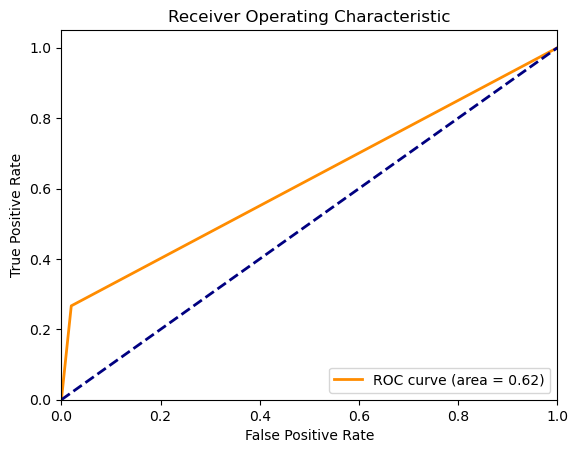

In [21]:
fpr, tpr, _ = roc_curve(out_values, pred_values)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Convert and save the model.
# DON'T RUN, IT CRASHES THE NOTEBOOK IF USING KERAS 3:
# https://github.com/tensorflow/tensorflow/issues/64273

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.allow_custom_ops = False  # Ensuring only supported ops are allowed; set to True if custom ops are necessary.
tflite_model = converter.convert()

with open('ebola-pediatric-diagnosis/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/tmpjgv3rjde/assets


INFO:tensorflow:Assets written to: /var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/tmpjgv3rjde/assets
2024-08-02 00:34:08.678548: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-08-02 00:34:08.678561: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-08-02 00:34:08.678760: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/tmpjgv3rjde
2024-08-02 00:34:08.679124: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-08-02 00:34:08.679133: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/tmpjgv3rjde
2024-08-02 00:34:08.680044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-08-02 00:34:08.680274: I tensorflow/cc/saved_model/load